# О датасете

Данный [датасет](https://www.kaggle.com/datasets/mrdaniilak/russia-real-estate-2021/data) содержит данные о рынке недвижимости в России за $2021$ год.   
Настоящее исследование направлено на анализирование рынка недвижимости и создание модели машинного обучения для прогнозирования цен на квартиры в регионе Санкт-Петербург.
Описание столбцов датасета:  
* **date** – дата публикации объявления;  
* **price** – цена (в рублях);  
* **level** – этаж квартиры;  
* **levels** – количество этажей;
* **rooms** – количество жилых комнат. Если значение равно "-1", то это означает "однокомнатная квартира";  
* **area** – общая площадь квартиры;  
* **kitchen_area** – площадь кухонной зоны;  
* **geo_lat** – географическая широта;  
* **geo_lon** – географическая долгота;  
* **building_type** – тип дома:
    * 0 - неизвестно;  
    * 2 - другой;  
    * 2 - панельный;  
    * 3 - монолитный;  
    * 4 - кирпичный;  
    * 5 - блочный;  
    * 6 - деревянный.
* **object_type** – тип квартиры:
    * 0 - вторичный рынок недвижимости;  
    * 2 - новостройка.  
* **postal_code** – почтовый индекс;  
* **street_id** – идентификационный номер улицы;  
* **id_region** – регион России. Всего в стране $85$ субъектов;  
* **house_id** – идентификационный номер дома.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk
import plotly_express as px
import folium
from folium.plugins import HeatMap

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import statsmodels.api as sm

%matplotlib inline

# Сделаем автоподгрузку всех изменений при перепрогонке ячейки
%load_ext autoreload
%autoreload 2

In [2]:
pd.set_option('display.float_format', '{:.8f}'.format)
pd.set_option('future.no_silent_downcasting', True)

In [3]:
# Стиль
plt.style.use('cyberpunk')

In [4]:
# Параметры шрифта
plt.rcParams.update({'font.size': 13})

In [5]:
df = pd.read_csv('input_data.csv', sep=';')

In [6]:
df.head()

,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,id_region,house_id
0,2021-01-01,2451300,15,31,1,30.30000000,0.00000000,56.78011240,60.69935480,0,2,620000.00000000,NaN,66,1632918.00000000
1,2021-01-01,1450000,5,5,1,33.00000000,6.00000000,44.60815420,40.13838140,0,0,385000.00000000,NaN,1,NaN
2,2021-01-01,10700000,4,13,3,85.00000000,12.00000000,55.54006010,37.72511240,3,0,142701.00000000,242543.00000000,50,681306.00000000
3,2021-01-01,3100000,3,5,3,82.00000000,9.00000000,44.60815420,40.13838140,0,0,385000.00000000,NaN,1,NaN
4,2021-01-01,2500000,2,3,1,30.00000000,9.00000000,44.73868460,37.71366810,3,2,353960.00000000,439378.00000000,23,1730985.00000000


In [7]:
df.shape

(11358150, 15)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11358150 entries, 0 to 11358149
Data columns (total 15 columns):
 #   Column         Dtype  
---  ------         -----  
 0   date           object 
 1   price          int64  
 2   level          int64  
 3   levels         int64  
 4   rooms          int64  
 5   area           float64
 6   kitchen_area   float64
 7   geo_lat        float64
 8   geo_lon        float64
 9   building_type  int64  
 10  object_type    int64  
 11  postal_code    float64
 12  street_id      float64
 13  id_region      int64  
 14  house_id       float64
dtypes: float64(7), int64(7), object(1)
memory usage: 1.3+ GB


In [9]:
df.describe()

,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,id_region,house_id
count,11358150.00000000,11358150.00000000,11358150.00000000,11358150.00000000,11358150.00000000,11358150.00000000,11358150.00000000,11358150.00000000,11358150.00000000,11358150.00000000,10850379.00000000,7152596.00000000,11358150.00000000,8096207.00000000
mean,6787516.41462492,6.42667468,11.76265792,1.71941707,53.10355873,-2.67407085,54.40393955,52.29570286,1.01781998,0.52753661,403171.65910094,352562.32868038,51.25515300,1703792.31330214
std,197711828.42574266,5.28314447,7.21844132,1.15760623,27.12844868,32.41854933,4.58296200,21.83898562,1.56207732,0.88135034,195961.83978464,136648.50776998,22.50526798,640457.77633430
min,0.00000000,0.00000000,0.00000000,-1.00000000,1.00000000,-100.00000000,41.43758500,-173.21891100,0.00000000,0.00000000,0.00000000,116187.00000000,1.00000000,588606.00000000
25%,2600000.00000000,2.00000000,5.00000000,1.00000000,36.50000000,0.00000000,53.19411400,37.63847250,0.00000000,0.00000000,196158.00000000,233915.00000000,31.00000000,1162465.00000000
50%,3995000.00000000,5.00000000,10.00000000,2.00000000,46.70000000,6.50000000,55.64687800,42.02111390,0.00000000,0.00000000,400007.00000000,350222.00000000,54.00000000,1703143.00000000
75%,6500000.00000000,9.00000000,17.00000000,2.00000000,63.00000000,10.50000000,56.87361720,65.47322200,2.00000000,2.00000000,625007.00000000,470537.00000000,72.00000000,2255297.00000000
max,635552400000.00000000,50.00000000,50.00000000,9.00000000,499.90000000,408.00000000,73.50889500,179.25830300,6.00000000,2.00000000,862163.00000000,588597.00000000,200.00000000,2839173.00000000


# Обработка пропусков

In [10]:
df.isnull().sum()

date                   0
price                  0
level                  0
levels                 0
rooms                  0
area                   0
kitchen_area           0
geo_lat                0
geo_lon                0
building_type          0
object_type            0
postal_code       507771
street_id        4205554
id_region              0
house_id         3261943
dtype: int64

In [11]:
categorial_features = list(df.select_dtypes('object').columns)
numerical_features = list(set(df.columns) - set(categorial_features))

In [12]:
categorial_features

['date']

In [13]:
numerical_features

['object_type',
 'price',
 'building_type',
 'id_region',
 'house_id',
 'levels',
 'area',
 'kitchen_area',
 'rooms',
 'geo_lat',
 'street_id',
 'level',
 'postal_code',
 'geo_lon']

In [14]:
for feature in categorial_features:
    df[feature] = df[feature].fillna(df[feature].mode()[0])

for feature in numerical_features:
    df[feature] = df[feature].fillna(df[feature].mean())

In [15]:
df.isnull().sum()

date             0
price            0
level            0
levels           0
rooms            0
area             0
kitchen_area     0
geo_lat          0
geo_lon          0
building_type    0
object_type      0
postal_code      0
street_id        0
id_region        0
house_id         0
dtype: int64

In [16]:
df.head()

,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,id_region,house_id
0,2021-01-01,2451300,15,31,1,30.30000000,0.00000000,56.78011240,60.69935480,0,2,620000.00000000,352562.32868038,66,1632918.00000000
1,2021-01-01,1450000,5,5,1,33.00000000,6.00000000,44.60815420,40.13838140,0,0,385000.00000000,352562.32868038,1,1703792.31330214
2,2021-01-01,10700000,4,13,3,85.00000000,12.00000000,55.54006010,37.72511240,3,0,142701.00000000,242543.00000000,50,681306.00000000
3,2021-01-01,3100000,3,5,3,82.00000000,9.00000000,44.60815420,40.13838140,0,0,385000.00000000,352562.32868038,1,1703792.31330214
4,2021-01-01,2500000,2,3,1,30.00000000,9.00000000,44.73868460,37.71366810,3,2,353960.00000000,439378.00000000,23,1730985.00000000


# Обработка дубликатов

In [17]:
df.duplicated().sum()

396685

In [18]:
df = df.drop_duplicates()

In [19]:
df.duplicated().sum()

0

# Выделение региона

In [20]:
# Выделяем регион Санкт-Петербург
df_sp = df[df['id_region'] == 78]

In [21]:
df_sp = df_sp.drop('id_region', axis=1)

In [22]:
df_sp.shape

(743794, 14)

In [23]:
df_sp['date'] = pd.to_datetime(df_sp['date'])

In [24]:
# Вместо столбца date добавляем month – количество месяцев,
# в течение которых висит объявление
df_sp['month'] = df_sp['date'].dt.month
df_sp = df_sp.drop('date', axis=1)

In [25]:
df_sp.head()

,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,house_id,month
15,8865000,10,13,2,66.70000000,14.60000000,59.85117870,30.41165730,4,2,192288.00000000,569976.00000000,1690045.00000000,1
63,4200000,12,25,-1,25.80000000,-100.00000000,60.03688920,30.22612280,3,2,190000.00000000,291085.00000000,2484205.00000000,1
99,6574995,10,11,-1,31.00000000,-100.00000000,59.93674420,30.25179990,3,0,199406.00000000,172995.00000000,1780424.00000000,1
108,7068330,12,13,1,42.30000000,18.70000000,55.63842900,37.65291200,0,2,403171.65910094,352562.32868038,1703792.31330214,1
151,8865000,11,13,2,66.70000000,14.60000000,59.85117870,30.41165730,4,2,192288.00000000,569976.00000000,1690045.00000000,1


# Работа с выбросами

In [ ]:
fig = px.density_mapbox(
    df_sp,
    lat='geo_lat',
    lon='geo_lon',
    radius=10,
    center=dict(lat=df_sp['geo_lat'].mean(), lon=df_sp['geo_lon'].mean()),
    zoom=3,
    mapbox_style='open-street-map'
)
fig.show()

In [27]:
z_geo_lat = np.abs(st.zscore(df_sp['geo_lat']))
z_geo_lon = np.abs(st.zscore(df_sp['geo_lon']))
df_sp = df_sp[(z_geo_lat < 2.5) & (z_geo_lon < 2.5)]

In [ ]:
fig = px.density_mapbox(
    df_sp,
    lat='geo_lat',
    lon='geo_lon',
    radius=10,
    center=dict(lat=df_sp['geo_lat'].mean(), lon=df_sp['geo_lon'].mean()),
    zoom=7,
    mapbox_style='open-street-map'
)
fig.show()

In [29]:
# Удаление выбросов с помощью метода межквартильного размаха (IQR)
Q1 = df_sp['price'].quantile(0.15)
Q3 = df_sp['price'].quantile(0.9)
IQR = Q3 - Q1
df_sp = df_sp[(df_sp['price'] > (Q1 - 1.5 * IQR)) & (df_sp['price'] < (Q3 + 1.5 * IQR))]

Q1 = df_sp['area'].quantile(0.15)
Q3 = df_sp['area'].quantile(0.9)
IQR = Q3 - Q1
df_sp = df_sp[(df_sp['area'] > (Q1 - 1.5 * IQR)) & (df_sp['area'] < (Q3 + 1.5 * IQR))]

Q1 = df_sp['kitchen_area'].quantile(0.15)
Q3 = df_sp['kitchen_area'].quantile(0.9)
IQR = Q3 - Q1
df_sp = df_sp[(df_sp['kitchen_area'] > (Q1 - 1.5 * IQR)) & (df_sp['kitchen_area'] < (Q3 + 1.5 * IQR))]

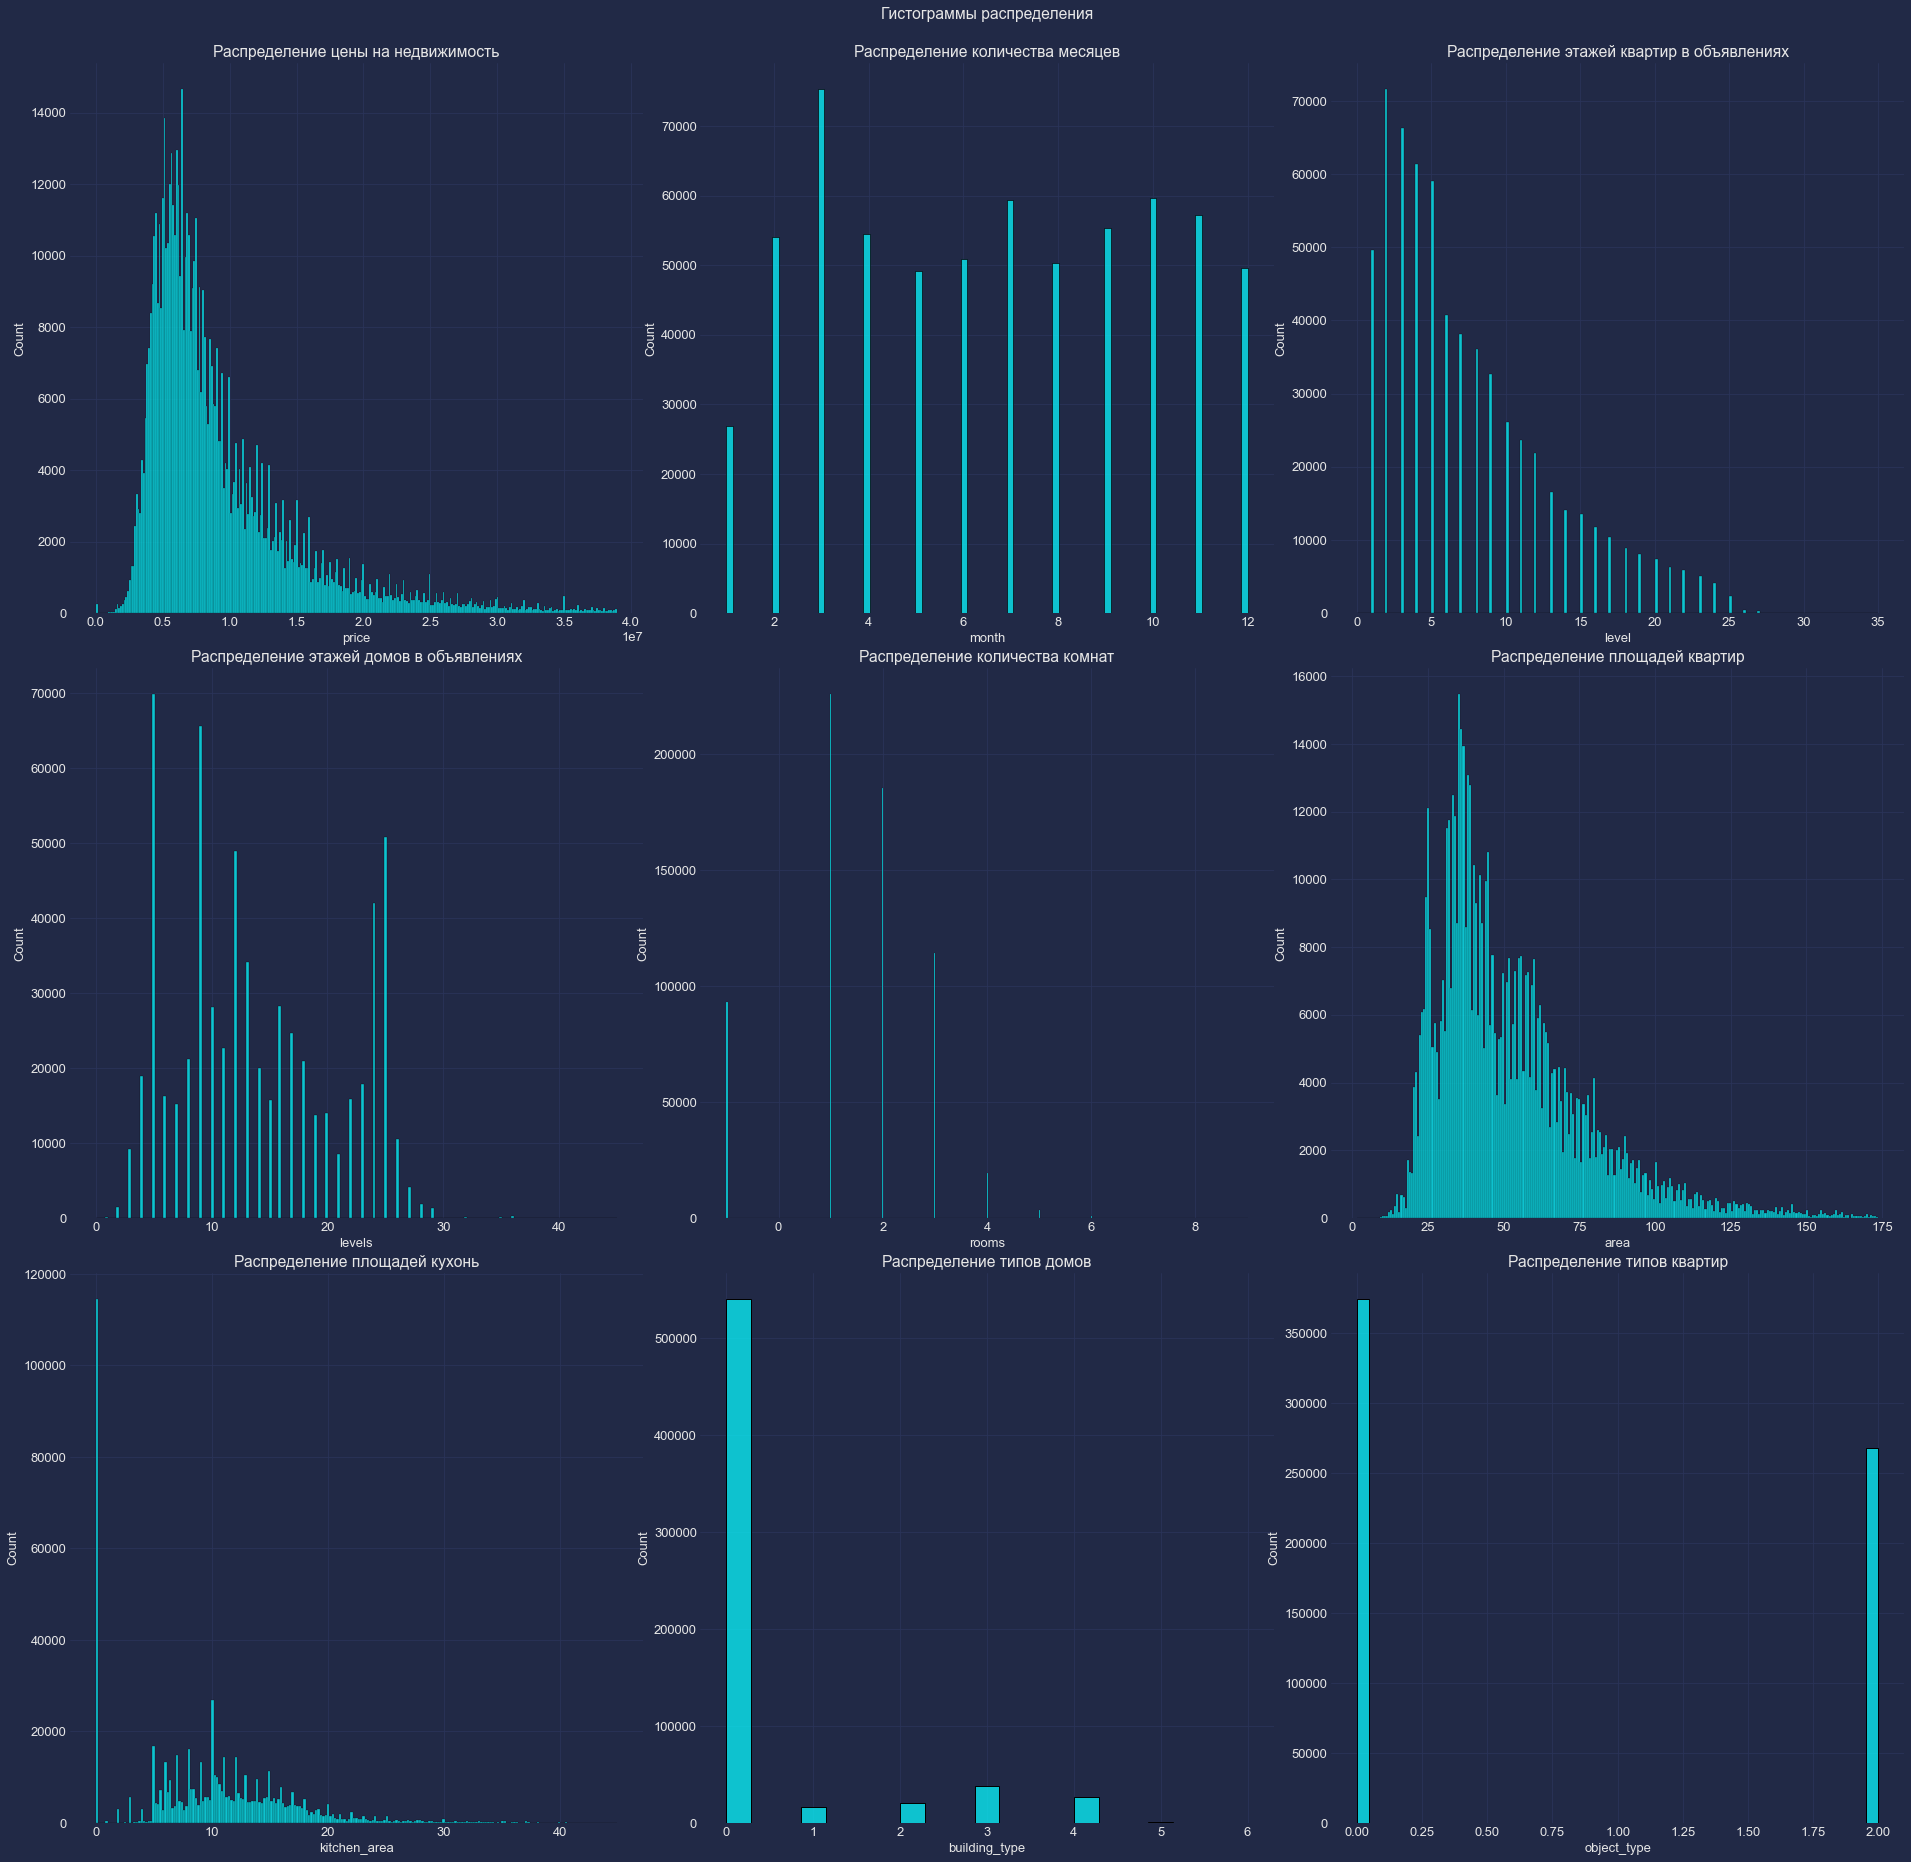

In [30]:
fig, axes = plt.subplots(3, 3, figsize=(26, 26))
fig.subplots_adjust(top=0.95, bottom=0.01, left=0.01, right=0.99, hspace=0.1, wspace=0.1)
fig.suptitle('Гистограммы распределения')

sns.histplot(data=df_sp['price'], ax=axes[0, 0])
axes[0, 0].set_title('Распределение цены на недвижимость')

sns.histplot(data=df_sp['month'], ax=axes[0, 1])
axes[0, 1].set_title('Распределение количества месяцев')

sns.histplot(data=df_sp['level'], ax=axes[0, 2])
axes[0, 2].set_title('Распределение этажей квартир в объявлениях')

sns.histplot(data=df_sp['levels'], ax=axes[1, 0])
axes[1, 0].set_title('Распределение этажей домов в объявлениях')

sns.histplot(data=df_sp['rooms'], ax=axes[1, 1])
axes[1, 1].set_title('Распределение количества комнат')

sns.histplot(data=df_sp['area'], ax=axes[1, 2])
axes[1, 2].set_title('Распределение площадей квартир')

sns.histplot(data=df_sp['kitchen_area'], ax=axes[2, 0])
axes[2, 0].set_title('Распределение площадей кухонь')

sns.histplot(data=df_sp['building_type'], ax=axes[2, 1])
axes[2, 1].set_title('Распределение типов домов')

sns.histplot(data=df_sp['object_type'], ax=axes[2, 2])
axes[2, 2].set_title('Распределение типов квартир')

plt.show()

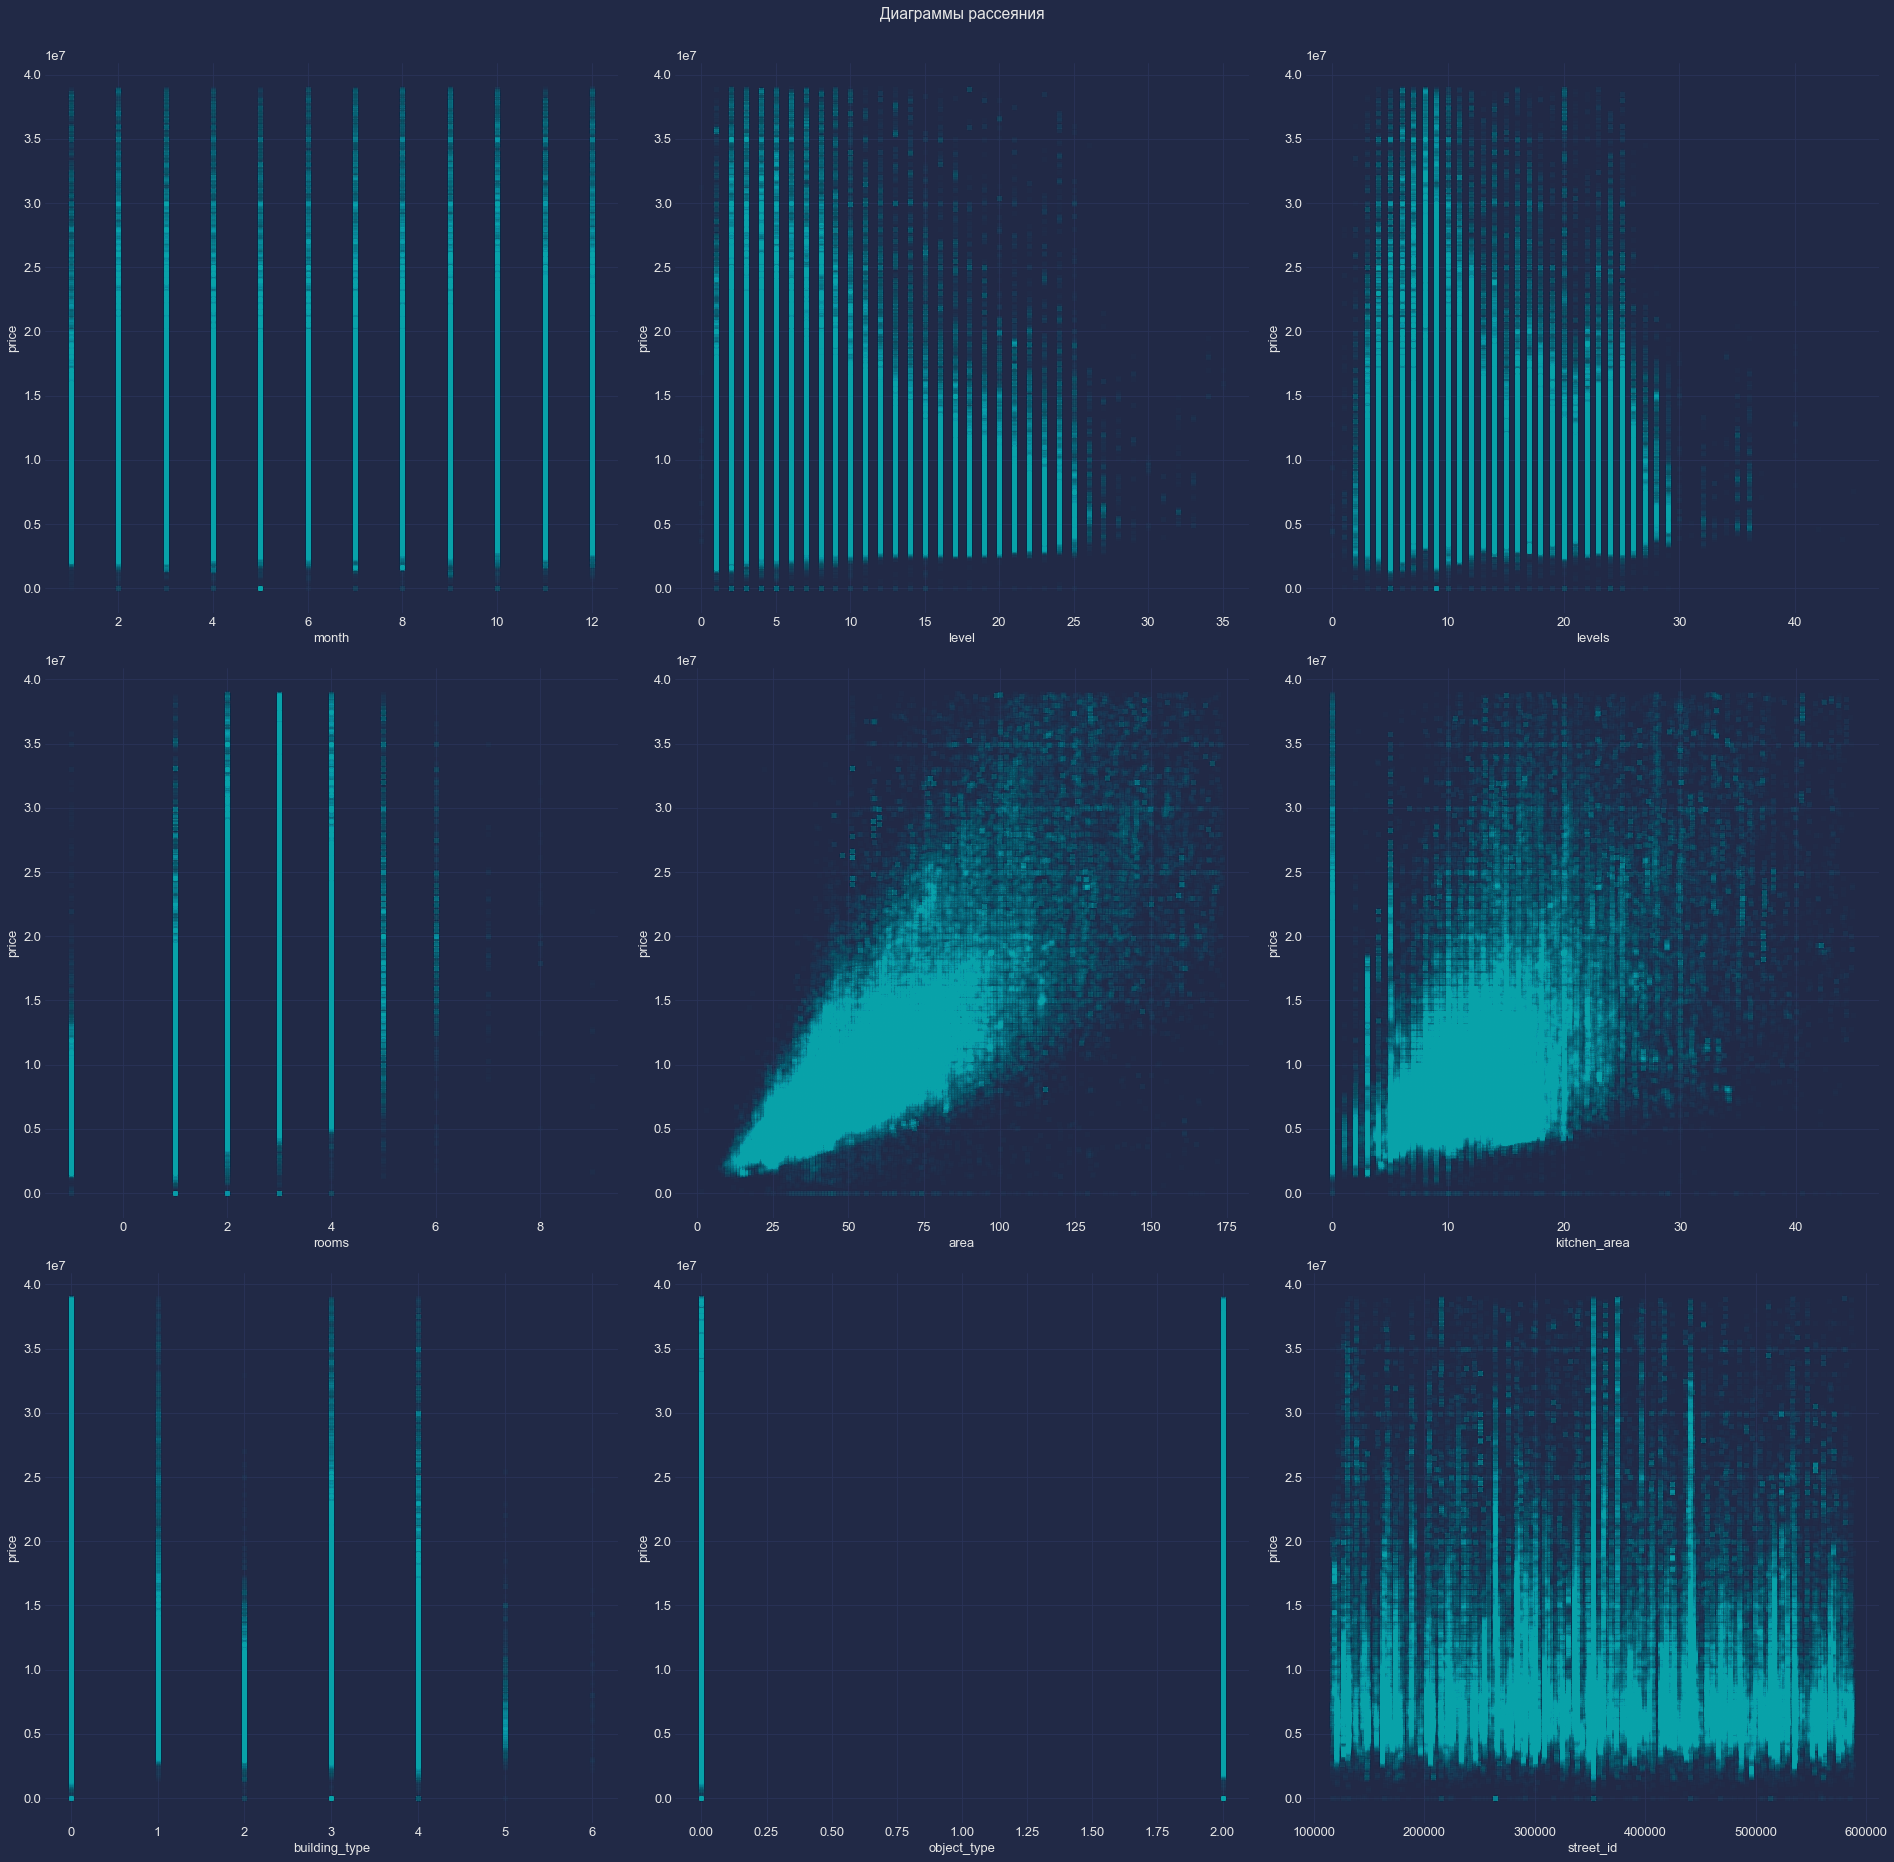

In [31]:
fig, axes = plt.subplots(3, 3, figsize = (26, 26))
fig.subplots_adjust(top=0.95, bottom=0.01, left=0.01, right=0.99, hspace=0.1, wspace=0.1)
fig.suptitle('Диаграммы рассеяния')

sns.scatterplot(x='month', y='price', data=df_sp, ax=axes[0, 0], alpha=0.01)
sns.scatterplot(x='level', y='price', data=df_sp, ax=axes[0, 1], alpha=0.01)
sns.scatterplot(x='levels', y='price', data=df_sp, ax=axes[0, 2], alpha=0.01)
sns.scatterplot(x='rooms', y='price', data=df_sp, ax=axes[1, 0], alpha=0.01)
sns.scatterplot(x='area', y='price', data=df_sp, ax=axes[1, 1], alpha=0.01)
sns.scatterplot(x='kitchen_area', y='price', data=df_sp, ax=axes[1, 2], alpha=0.01)
sns.scatterplot(x='building_type', y='price', data=df_sp, ax=axes[2, 0], alpha=0.01)
sns.scatterplot(x='object_type', y='price', data=df_sp, ax=axes[2, 1], alpha=0.01)
sns.scatterplot(x='street_id', y='price', data=df_sp, ax=axes[2, 2], alpha=0.01)

plt.show()

In [32]:
df_sp[df_sp['price'] <= 1e5]

,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,house_id,month
192456,9200,3,20,3,62.00000000,10.00000000,59.83004140,30.19260850,0,0,198261.00000000,479930.00000000,2709476.00000000,1
898669,18800,5,19,3,87.50000000,16.00000000,59.90418900,30.31480800,0,0,196084.00000000,440019.00000000,1535617.00000000,2
1006394,5200,7,16,-1,28.00000000,0.00000000,59.97952900,30.37347700,0,0,195197.00000000,528715.00000000,1078803.00000000,2
1062729,20000,6,9,1,36.00000000,6.00000000,60.00366000,30.41600300,0,0,195256.00000000,415192.00000000,2632906.00000000,2
1132082,6900,1,3,2,37.00000000,0.00000000,59.93094510,30.28604770,0,0,190121.00000000,574497.00000000,2258986.00000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10142000,8800,2,12,3,63.00000000,7.00000000,60.02418450,30.37704730,0,0,195427.00000000,251720.00000000,1874802.00000000,11
10146292,7100,3,5,3,56.00000000,6.90000000,60.01114740,30.43268990,0,0,195273.00000000,121163.00000000,594630.00000000,11
10220927,6400,16,27,1,41.00000000,10.50000000,60.07372430,30.33840760,0,0,194358.00000000,535271.00000000,1648370.00000000,11
10224336,7500,4,9,2,47.00000000,8.20000000,60.03558930,30.43069640,0,0,195299.00000000,121163.00000000,594630.00000000,11


In [33]:
# Видим, что есть наблюдения с ценой, меньше либо равной нуля.
# Также есть наблюдения с очень низкой ценой – их следует удалить.
df_sp = df_sp[df_sp['price'] > 1e5]

In [34]:
df_sp[df_sp['kitchen_area'] > df_sp['area']].head()

,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,house_id,month
10988314,19000000,7,10,1,42.00000000,42.60000000,59.96354000,30.27317000,0,0,197198.00000000,413628.00000000,2631009.00000000,12
11034646,3100000,2,20,1,18.00000000,18.90000000,60.08013180,30.26436540,0,2,194358.00000000,368563.00000000,1987401.00000000,12
11075111,19000000,7,11,1,42.00000000,42.60000000,59.96354000,30.27317000,0,0,197198.00000000,413628.00000000,2631009.00000000,12
11355311,14467880,2,6,1,17.32000000,18.10000000,59.98774700,30.33438100,0,2,194100.00000000,528681.00000000,1078778.00000000,12


In [35]:
# Есть небольшое количество наблюдений, для которых общая площадь квартиры меньше площади кухни.
# Их также следует удалить.
df_sp = df_sp[df_sp['kitchen_area'] <= df_sp['area']]

In [36]:
# Есть ли наблюдения, для которых номер этажа больше общего количества этажей?
df_sp[df_sp['level'] > df_sp['levels']].head()

,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,house_id,month
400087,9350000,3,0,2,48.00000000,10.00000000,59.85130730,30.02164310,0,0,198515.00000000,300413.00000000,1369322.00000000,1
722839,4650000,5,0,1,32.00000000,10.00000000,60.03054930,30.14250390,0,0,197229.00000000,340956.00000000,1981041.00000000,2
1331905,4100000,5,0,-1,26.75000000,0.00000000,59.95197900,30.44758800,0,0,195248.00000000,352562.32868038,1703792.31330214,2
1362434,4300000,10,0,-1,24.80000000,0.00000000,59.83085690,30.24514880,0,0,198217.00000000,373889.00000000,1366944.00000000,2
1865193,13863342,14,13,3,77.54000000,13.96000000,59.99012500,30.32756400,0,2,197343.00000000,296436.00000000,1364390.00000000,3


In [37]:
df_sp = df_sp[df_sp['level'] <= df_sp['levels']]

In [38]:
# Есть ли квартиры с нулевой или отрицательной площадью?
df_sp[df_sp['area'] <= 0]

,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,house_id,month


In [39]:
# Есть ли кухни с нулевой или отрицательной площадью?
df_sp[df_sp['kitchen_area'] < 0]

,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,house_id,month


# Отбор признаков

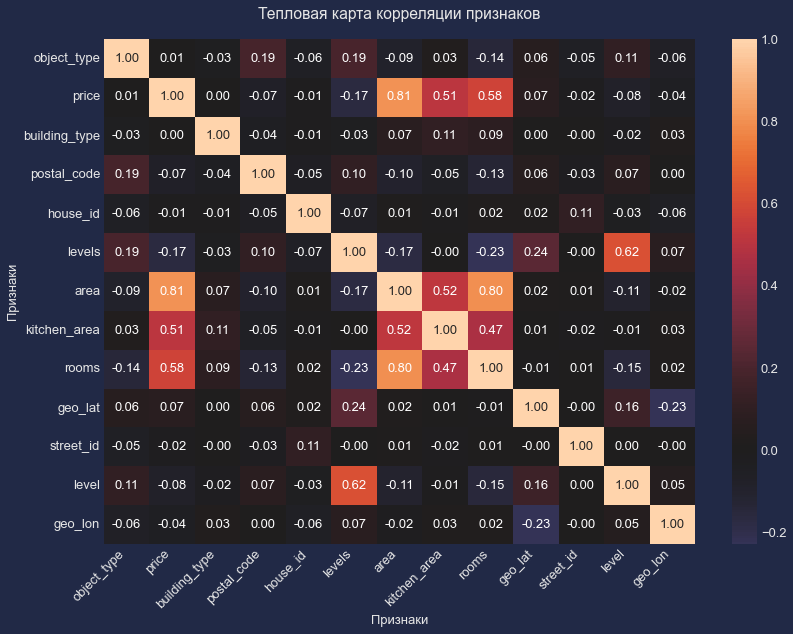

In [40]:
# Построение матрицы корреляции
features_for_map = list(set(numerical_features) - set(['id_region']))
corr = df_sp[features_for_map].corr()

fig = plt.figure(figsize=(12, 9))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, center=0, annot=True, fmt=".2f")
plt.title('Тепловая карта корреляции признаков', pad=20)
plt.xlabel('Признаки')
plt.ylabel('Признаки')
# Вращение меток для улучшения читаемости
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Видна высокая положительная корреляция между ценой и следующими факторами: площадь квартиры ($0.76$), количество комнат ($0.58$), площадь кухни ($0.45$).
Факторы object_type, building_type, street_id, house_id почти не влияют на ценообразование, поэтому их в модель можно не включать. Кажется, что есть сильная корреляция между area и rooms, area и kitchen_area, поэтому для избежания проблемы мультиколлинеарности и, как следствие, неточности оценок коэффициентов линейной регрессии, стоит рассмотреть вариант включения в модель признаков, сочетающих в себе информацию из обеих коррелирующих переменных.

In [41]:
df_sp['kitchen_to_total_area_ratio'] = df_sp['kitchen_area'] / df_sp['area']
df_sp['avg_room_area'] = df_sp['area'] / df_sp['rooms']

In [42]:
df_sp.drop(['object_type', 'building_type', 'street_id', 'house_id'], axis=1, inplace=True)

# Масштабирование данных

In [43]:
scaler = StandardScaler()
cols_for_scaler = list(set(df_sp.columns) - set(['price']))
df_sp[cols_for_scaler] = scaler.fit_transform(df_sp[cols_for_scaler])

# Обучение модели

In [44]:
X = df_sp.drop('price', axis=1).reset_index(drop=True)
y = np.log10(df_sp['price'])

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [46]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Коэффициент детерминации R^2
r_squared = model.score(X_test, y_test)
mae = mean_absolute_error(10 ** y_test, 10 ** y_pred)
print(f'R^2: {r_squared}')
print(f'MAE: {mae}')

R^2: 0.7242571068076764
MAE: 2155219.4038479757


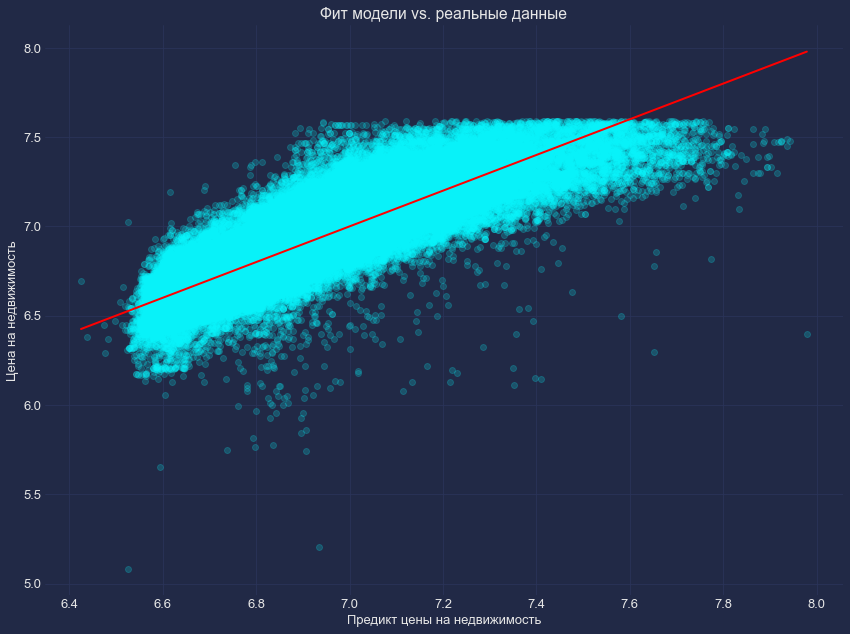

In [47]:
plt.figure(figsize=(12, 9))
plt.title('Фит модели vs. реальные данные')
sns.regplot(x=y_pred, y=y_test, scatter_kws={'alpha':0.2}, line_kws={'color':'red', 'linewidth':2})

#plt.plot(y_test, y_pred, color='red', linewidth=3)

plt.xlabel('Предикт цены на недвижимость')
plt.ylabel('Цена на недвижимость')

plt.tight_layout()
plt.show()

Коэффициент детерминации довольно высокий – это хороший показатель, указывающий на хороший фит модели к данным. При этом средняя абсолютная ошибка также получилась высокой, что не очень хороший знак. На самом деле, в контексте данной задачи подобный результат не удивление и может свидетельствовать о большом разбросе цен в датасете. Вопрос в том, как его интерпертировать – зависит от поставленных бизнесом условий.